In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
from IPython.display import display

# 시각 피질 구조
시각 피질 안의 많은 뉴런이 작은 국부 수용장(local receptive field)를 가진다. 즉 뉴런들이 시냐의 일부 범위 안에 있는 시각 자극에만 반응한다는 뜻인데, 뉴런의 수용장들은 서로 겹칠 수 있어서 합치면 전체 시야를 감싸게 된다. 어떤 뉴런은 수평선의 이미지에만 반응하는 반면 다른 뉴런은 다른 각도의 선분에 반응한다.

이런 관찰은 고수준 뉴런이 이웃한 저수준 뉴런의 출력에 기반한다는 아이디어를 이끌어냈다.

이미지 인식에 완전 연결층의 심층 신경망을 사용하게 되면 아주 많은 파라미터가 만들어지기 때문에 문제가 된다. 가령 100x100 이미지는 10,000 픽셀로 이뤄져 있고 여기에 연결되는 첫 번째 은닉층의 뉴런 1,000개로 만들어도 연결이 총 천만개가 된다. 여러개의 은닉층들을 모두 합하면 어마어마한 개수의 가중치가 생기게 된다.


# 합성곱 층
첫 번째 합성곱 층의 뉴런은 입력 이미지의 모든 픽셀에 연결되는 것이 아니라 합성곱 층 뉴런의 수용장 안에 있는 픽셀에만 연결된다.<br>두 번째 합성곱 층에 잇는 각 뉴런은 첫 번째 층의 일부 영역 안에 위치한 뉴런에 연결된다.(p544 그림 참조)
<br>이런 구조는 네트워크가 첫 번째 은닉층에서는 작은 저수준 특성에 집중하고, 그다음 은닉층에서는 더 큰 고수준 특성으로 조합해나가도록 도와준다.

이전의 신경망은 한 줄로 길게 늘어선 뉴런으로 구성되었기에 이미지를 주입하기 전에 1D 배열로 펼쳐야했으나 CNN에서는 각 층이 2D로 표현되므로 뉴런을 그에 상응하는 입력과 연결하기가 더 쉽다.

어떤 층의 i행,j열에 있는 한 뉴런은 이전 층의 i에서 i+$f_h$-1까지의 행과 j에서 j+$f_w$-1까지의 열에 있는 뉴런의 출력에 연결된다.($f_h$는 수용장의 높이, $f_w$는 수용장의 너비).<br> 높이와 너비를 이전 층과 같게 하기 위해 입력의 주위에 0을 추가하는 것이 일반적이다. 이를 "제로 패딩(zero padding)"이라고 한다.

수용장 사이에 간격을 두어 큰 입력층을 훨씬 작은 층에 연결하는 것도 가능하다. 이렇게 함으로써 계산 복잡도를 크게 낮춰준다. 한 수용장과 다음 수용장의 간격을 "stride(스트라이드)"라고 한다.<br>
ex) 5x7 입력층이 3x3 수용장과 스트라이드 2를 이용해 3x4로 연결된다.(스트라이드는 가로 세로가 달라도 된다.)<br>
상위층의 i행, j열에 있는 뉴런이 이전 층의 i$ {\cdot}s_h$에서 i${\cdot}s_h$+$f_h$-1까지의 행과 j${\cdot}s_w$에서 j${\cdot}s_w$+$f_w$-1까지의 열에 위치한 뉴런과 연결된다.

## 필터

In [48]:
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')/255
flower = load_sample_image('flower.jpg')/255
images = np.array([china,flower])
(batch_size,height,width,channels)=images.shape
print(batch_size,height,width,channels)

2 427 640 3


In [64]:
filters = np.zeros(shape=[7,7,channels,2])
filters[:,3,:,0] = 1 # 수직선
filters[3,:,:,1] = 1 # 수평선

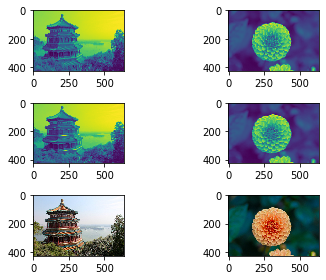

In [97]:
outputs = tf.nn.conv2d(images,filters,strides=1,padding='SAME')
fig,ax = plt.subplots(3,2)
ax[0,0].imshow(outputs[0,:,:,0])
ax[1,0].imshow(outputs[0,:,:,1])  # 첫 번째 이미지의 두 번째 특성 맵을 그린다.
ax[0,1].imshow(outputs[1,:,:,0])
ax[1,1].imshow(outputs[1,:,:,1])
ax[2,0].imshow(china)
ax[2,1].imshow(flower)
plt.tight_layout()

In [68]:
from PIL import Image
im = Image.open('고양이.jpg')
im_array = np.array(im)[:900]/255
im_array.shape

(900, 443, 3)

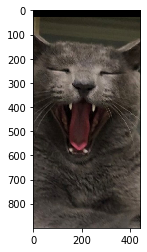

In [41]:
plt.imshow(im_array)

In [70]:
expanded_im = tf.expand_dims(im_array,0)
expanded_im.shape

TensorShape([1, 900, 443, 3])

In [93]:
# 수직필터
vertical_filter = np.zeros(shape=[7,7,3,1])
vertical_filter[:,3,:] = 1

# 수평필터
horizontal_filter = np.zeros(shape=[7,7,3,1])
horizontal_filter[3,:,:] = 1

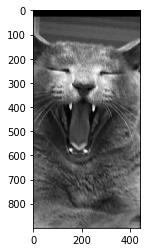

In [101]:
output = tf.nn.conv2d(expanded_im,vertical_filter,strides=1,padding='SAME')
plt.imshow(output[0,:,:,0],cmap='gray')

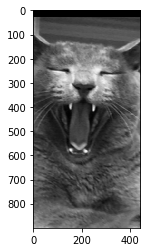

In [102]:
output2 = tf.nn.conv2d(expanded_im,horizontal_filter,strides=1,padding='SAME')
plt.imshow(output2[0,:,:,0],cmap='gray')

In [87]:
np.mean(output == output2)

0.031136192626034613

층의 전체 뉴런에 적용된 하나의 필터는 하나의 "특성 맵(feature map)"을 만든다. 이 맵은 필터를 가장 크게 활성화시키는 이미지의 영역을 강조한다.<br>
일반적으로 수동으로 필터를 직접 정의할 필요는 없다. 학습 도중 합성곱 층이 자동으로 해당 문제에서 가장 유용한 필터를 찾고 상위층은 이들을 연결해 더 복잡한 패턴을 학습한다.

## 여러가지 특성 맵 찾기
이미 위에서 필터의 모양을 정의한 것처럼, 실제 합성곱 층은 여러 가지 필터를 가지고 필터마다 하나의 특성 맵을 출력하므로 3D로 표현하는 것이 더 정확하다. 각 특성 맵의 픽셀은 하나의 뉴런에 해당하고 하나의 특성 맵 안에서는 모든 뉴런이 같은 파라미터(가중치,편향)를 공유하지만, 다른 특성 맵에 있는 뉴런은 다른 파라미터를 사용한다. 한 뉴런의 수용장은 이전 층에 있는 모든 특성 맵에 걸쳐 확장되는데 다시 말해 하나의 합성곱 층이 입력에 여러 필터를 동시에 적용하여 입력에 있는 여러 특징을 감지할 수 있는 것이다.

한 특성 맵에 있는 모든 뉴런이 같은 파라미터를 공유한다는 사실은 모델 전체 파라미터 수를 급격히 줄여준다. 보통의 DNN은 한 지점에 해당 패턴이 있어야만 인지할 수 있도록 학습되지만 CNN은 한 지점에서 인식된 패턴이 다른 지점에서 반복될 경우 이를 인지할 수 있다.

입력 이미지는 컬러 채널(channel)마다 하나씩 여러 서브 층으로 구성된다. 컬러 채널은 전형적으로 red,green,blue의 RGB 세 가지를 갖는다. 흑백 이미지는 하나의 채널만 갖는다. 위성 이미지는 가시광성 외 여러 파장의 빛이 기록돼 더 많은 채널을 갖는다.

합성곱 층에 있는 뉴런의 출력을 계산하는 식이 있으나 여기서는 생략(p549)

## 텐서플로우로 구현
코드는 위에 것을 참고하면 된다. 여기서는 코드에 대한 상술<br>
텐서플로우에서 각 입력 이미지는 \[높이,너비,채널\]의 3D 형태이다. 여기에 미니배치가 더해져 \[미니배치 크기,높이,너비,채널\]의 4D 텐서로 이뤄진다.

합성곱 층의 가중치는 \[$f_h$,$f_w$,$f_{n'}$,$f_n$\]의 4D 텐서로 이뤄진다(\[높이,너비,입력채널 수,출력채널 수\]). 합성곱 층의 편향은 \[$f_n$\] 형태의 1D 텐서이다.

함수 부연설명 : tf.nn.conv2d. <br>padding="VALID"를 하면 제로 패딩 사용 X, 필터너비와 스트라이드 크기가 넘어가버리는 뉴런의 값은 무시한다. 이는 모든 뉴런의 수용장이 입력 안쪽 영역에만 놓인다는 의미이다.<br> padding="SAME"이면 제로 패딩을 사용해 출력 크기가 입력 뉴런 수를 스트라이드로 나누어 올림한 것과 같다. 필요하면 데이터 주변에 동일하게 0이 추가된다. stride=1인 경우 입,출력이 동일한 차원 갖는다.

In [ ]:
# keras에서는 합성곱 층을 생성하는 함수 역시 제공된다.
conv = keras.layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='same',activation='relu')

# 3x3 크기의 32개 필터를 스트라이드 1, 'same' 패딩을 사용하도록 Conv2D 층을 구성한 뒤 출력에는 ReLU 활성화 함수를 적용

# 풀링 층
주된 목적은 계산량과 메모리 사용량, (과대적합의 위험을 줄이기 위해) 파라미터 수를 줄이도록 입력 이미지의 축소본(부표본, subsample)을 만드는 것이다.<br>
합성곱 층에서와 마찬가지로 풀링 층의 각 뉴런은 이전 층의 작은 사각 영역 수용장 내에 있는 뉴런의 출력과 연결되어있다. 동일하게 크기, 스트라이드, 패딩 유형을 지정해야하는데 가중치는 존재하지 않는다. 최대 혹은 합산 같은 함수를 사용해 입력값을 조합하는 것이 전부다.

maxpooling은 계산량 등을 감소시키는 것 이외에 작은 변화에도 일정 수준의 '불변성'을 유지할 수 있게 만들어준다.<br>
ex)(p555)A는 이미지 원본이고, B,C는 A에서 각각 1픽셀, 2픽셀 씩 옆으로 이동한 이미지이다. A,B,C가 각각 2x2 커널에 스트라이드 2를 갖는 maxpooling층을 통과한다 가정한다면 A와 B는 동일한 출력을 얻게 된다.(=translation invariance) C의 출력은 약간 다르게 되는데 CNN에서 몇 개의 층마다 maxpooling 층을 추가하면 전체적으로 일정 수준의 이동 불변성을 얻게된다. 회전,확대,축소에 대해서도 어느정도 불변성을 제공하기에 분류 작업 등에서 작은 변화에 덜 민감해질 수 있다.

단점 역시 가지고 있는데 입력값의 많은 데이터를 손실할 수 있다. 어떤 어플리케이션의 경우 불변성이 필요하지 않을 수 있다. 입력의 작은 변화가 출력에도 상응하는 변화로 이어져야하는 '등변성'이 목표인 경우에는 약간 다르게 알고리즘을 적용해야한다.

In [ ]:
# 구현, 스트라이드의 기본값은 커널크기, 패딩의 기본값은 'valid'
max_pool = keras.layers.MaxPool2D(pool_size=2)

# MaxPool2D 외에 AvgPool2D 등 역시 존재, 평균 풀링은 정보 손실이 적고 최대 풀링은 이동 불변성이 강력하고 연산 비용이 적다.

깊이방향 풀링층 구성, 전역 평균 풀링층에 대해서는 책을 참고(p557)<br>
전역평균 풀링(특성맵의 평균 출력, 대부분의 정보 손실) : keras.layers.GlobalAvgPool2D()<br>
깊이방향 풀링층 : keras에 제공하는 함수가 없으므로 keras.layers.Lambda(lambda 함수로 직접 정의)

# CNN 구조
합성곱 층 몇개 (각각 ReLU 층을 그 뒤에) + 풀링층 + 다시 합성곱과 ReLU층 + 풀링층 + ...+ 완전 연결층

MNIST에 적용

In [127]:
mnist = keras.datasets.mnist
(X_train_full,y_train_full),(X_test,y_test) = mnist.load_data()

In [128]:
print(X_train_full.shape, y_test.shape)

(60000, 28, 28) (10000,)


In [129]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,y_train_full,test_size=0.2)

In [137]:
X_train = tf.expand_dims(X_train,-1)
X_test = tf.expand_dims(X_test,-1)
X_valid = tf.expand_dims(X_valid,-1)

In [138]:
X_train.shape

TensorShape([48000, 28, 28, 1])

In [139]:
# 보통 처음 합성곱 커널에는 큰 크기의 2이상 스트라이드를 사용한다. 너무 많은 정보를 잃지 않고 공간 방향 차원을 줄일 수 있다.
# 나머지 합성곱 층에는 작은 크기의 커널을 쌓는다. 5x5 1개보다 3x3 2개가 계산량도 적고 더 나은 성능을 낸다.

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,activation='relu',strides=1,padding='same',input_shape=[28,28,1]))
model.add(keras.layers.MaxPooling2D(2))  # 공간차원이 절반으로 줄어든다.
model.add(keras.layers.Conv2D(128,3,activation='relu',strides=1,padding='same'))
model.add(keras.layers.Conv2D(128,3,activation='relu',strides=1,padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(256,3,activation='relu',strides=1,padding='same'))
model.add(keras.layers.Conv2D(256,3,activation='relu',strides=1,padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10,activation='softmax'))

In [140]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 256)        

In [143]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
model.compile(loss='sparse_categorical_crossentropy',metrics=['acc'],optimizer='sgd')

In [ ]:
history = model.fit(X_train,y_train,batch_size=64,validation_data=(X_valid,y_valid),
                    epochs=30,callbacks=[early_stopping_cb])

99%의 성과를 보인다.<br>
몇 가지 특징
- 첫 째 층은 큰 필터와 스트라이드 1을 사용
- CNN이 출력층에 다다를수록 필터개수가 늘어난다.(64->128->256)<br>
    저수준 특성(작은 동심원, 수평선)의 개수는 적지만 이를 연결해 고수준 특성을 만들 수 있다.<br>
    풀링층 다음에는 필터 개수를 두 배로 늘리는 것이 일반적인 방법,<br>
    풀링층이 차원을 절반으로 줄이므로 계산비용을 늘리지 않고 특성 맵 개수를 두 배로 늘릴 수 있다.
- 밀집 층에서는 과대적합을 줄이기 위해 50%의 드롭아웃을 적용